In [1]:
# SEBASTIANS MODEL FORCED BY WHITE NOISE


import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import matplotlib.ticker as mticker

from model_params_functions import *
from figure_params import *


fontsize = 16
fontsize_ticks = 14


plt.rcParams.update({
    'font.family':         "sans-serif",
    'font.size':           fontsize,
    'xtick.labelsize':     fontsize_ticks,
    'ytick.labelsize':     fontsize_ticks,
    # 'figure.facecolor':    'white',
    'savefig.format':      'png',
    "mathtext.fontset":    "stixsans",
    })


In [2]:
path_data  = "data/simulations.nc"
path_pvals = "data/surrogate_pvalues_1000.nc"
data = xr.open_dataset(path_data)
pvals = xr.open_dataarray(path_pvals).to_dataset("indicator")

data["pAC1"] = pvals["AC1"]
data["pVariance"] = pvals["Variance"]
data["pSpCorr"] = pvals["SpCorr"]

B = data.B.values
i_max = int(data.time.where(data.Precipitation <= Pcrit).min()) #- 10
Bcritreached = B[i_max]

# Real

In [5]:
alpha = .1
lw = 3
lw_min_max = .3 
xlim = [B[0]+1,B[-1]-1]


def plot_ts(data, ax):
    # nice formatting of y-axis
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((0,0))
    ax.yaxis.set_major_formatter(formatter)
    # use custom colors
    ax.set_prop_cycle(cell_color_cycler)
    plt.sca(ax)
    # plot
    fgsc = data.mean("run").plot(x="B", hue="cell", ax=ax, lw=lw, add_legend=False)
    data.mean("run").isel(cell=0).plot(x="B", hue="cell", ax=ax, lw=lw, add_legend=False) # west cell should not be hidden
    data.min("run").plot(x="B", hue="cell", ax=ax, lw=lw_min_max, alpha=1, xincrease=False, add_legend=False)
    data.max("run").plot(x="B", hue="cell", ax=ax, lw=lw_min_max, alpha=1, xincrease=False, add_legend=False)
    ax.axvline(Bcritreached, color="black", zorder=1)
    ax.spines["bottom"].set_visible(False)
    ax.set_xlim(xlim)
    plt.setp(ax.get_xticklabels(), visible=False)
    return fgsc


def get_first_sigB(pvals, p): 
    return pvals.dropna("time", "all").B.where(pvals<p).max("time").dropna("run")


def plot_toe(pvals, p, ax, xticks=False):
    ypositions = np.linspace(0, 1, ncells+2)[1:-1]
    for i in range(ncells):
        bs = get_first_sigB(pvals.sel(cell=i), p) 
        nEmergence = len(bs)
        if nEmergence > 1:
            box = ax.boxplot(bs, 
                vert = False, 
                positions = [ypositions[i]], 
                manage_ticks = False,
                whis = (5, 95),
                widths =  1/(ncells+2),
                medianprops = {"lw":3},
                patch_artist=True,
                sym="")
            box["boxes"][0].set_facecolor(cell_color_list[i])
    ax.spines["top"].set_visible(False)
    ax.axvline(Bcritreached, color="black", zorder=1)
    ax.set_xticks(np.arange(B[0], B[-1]-1, -5))
    if not xticks: plt.setp(ax.get_xticklabels(), visible=False)
    else: plt.setp(ax.set_xticklabels(np.arange(B[0], B[-1]-1, -5)), visible=True)
    ax.set_yticks(ypositions[[0,3,6,9]])
    ax.set_yticks(ypositions[[1,2,4,5,7,8]], minor=True)
    ax.set_yticklabels(["west", "#4", "#7", "east"])
    ax.set_ylabel("cell")
    ax.set_xlim(xlim)

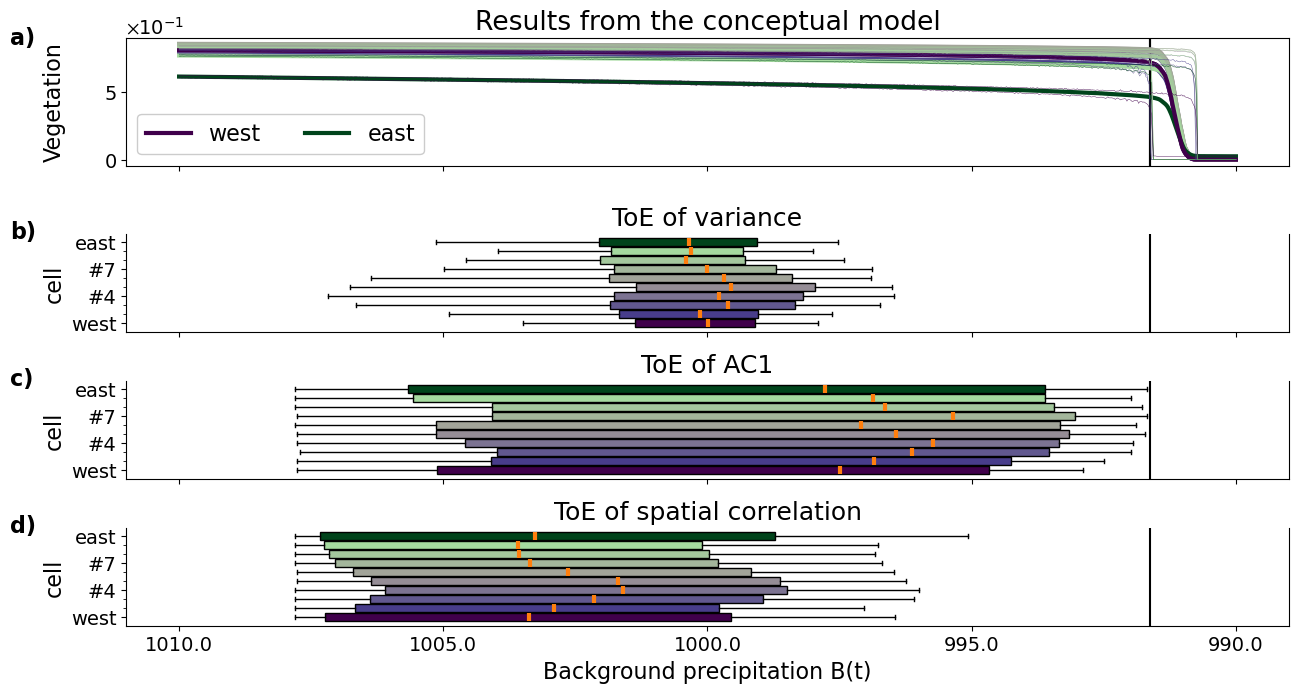

In [12]:
# PLOTS against bifurcation parameter
alpha = .1
lw = 3
lw_min_max = .3

p = 0.05
# We'll use two separate gridspecs to have different margins, hspace, etc
gs_top = plt.GridSpec(4, 1, top=0.95)
gs_base = plt.GridSpec(4, 1, hspace=0.5)
fig = plt.figure(figsize=(15,7))


# Top: VEGETATION
topax = fig.add_subplot(gs_top[0,:])
topax.set_prop_cycle(cell_color_cycler)
plt.sca(topax)
fgsc = plot_ts(data.Vegetation, ax=topax)
topax.spines["bottom"].set_visible(True)
topax.legend([fgsc[0], fgsc[-1]], ["west", "east"], ncol=2, loc='lower left', framealpha=1.)
topax.axvline(Bcritreached.max(), color="black", zorder=0)
topax.set_ylabel("Vegetation")
topax.set_xlabel("")
plt.setp(topax.get_xticklabels(), visible=False)
topax.set_title("Results from the conceptual model")
topax.set_xlim(xlim)


# The 3 shared CSD-indicator ToE axes
axes = [fig.add_subplot(gs_base[i,:], sharex=topax) for i in range(1, 4)]

# axis 1: VARIANCE
ax = axes[0]
plot_toe(data.pVariance, p, ax)
ax.set_title("ToE of variance", fontsize=18)
ax.set_xlabel("")

# axis 2: AC1
ax = axes[1]
plot_toe(data.pAC1, p, ax)
ax.set_title("ToE of AC1", fontsize=18)
ax.set_xlabel("")

# axis 3: Spatial Correlation
ax = axes[2]
plot_toe(data.pSpCorr, p, ax, xticks=True)
ax.set_title("ToE of spatial correlation", fontsize=18)
ax.set_xlabel("Background precipitation B(t)")


main_axes = [topax] + axes
fig.align_ylabels(main_axes)
label_axes2(main_axes, loc = (-.1, .95))

fig.savefig("../figs/fig04.png", bbox_inches='tight', transparent=True)